# Feedback Prize Effectiveness: Model Training and Validation (Longformer + GroupKFold + AMP + GradAccum)

This notebook covers the complete pipeline for training and validating a Longformer model to predict the effectiveness of discourse elements in student essays. Key changes from the previous version include:
1. **Model**: Using `allenai/longformer-base-4096` with `MAX_LEN = 1024`.
2. **Input Formulation**: Discourse elements are surrounded by context from the essay: `[CLS] type [SEP] text [SEP] context_before [SEP] context_after [SEP]`.
3. **Validation Strategy**: Using `GroupKFold` cross-validation, grouping by `essay_id`.
4. **Performance**: Implemented Automatic Mixed Precision (AMP) and Gradient Accumulation (2 steps) for potentially faster training and larger effective batch size.
5. **Setup and Configuration**: Importing necessary libraries and defining constants.
6. **Data Loading and Preprocessing**: Loading training data and essay texts.
7. **Target Encoding**: Converting categorical labels to numerical format.
8. **Tokenizer Initialization**: Setting up `LongformerTokenizerFast`.
9. **PyTorch Dataset and DataLoader Creation**: Defining custom Dataset and DataLoaders.
10. **Model Definition**: Loading `LongformerForSequenceClassification`.
11. **Optimizer, Scheduler, and Loss Function**: Configuring these for each fold.
12. **Training and Evaluation Loop**: Main loop for K-fold training and evaluation with AMP and gradient accumulation.
13. **Saving Best Models**: Storing model (config, weights) and tokenizer for each fold using `save_pretrained`.
14. **Reporting**: Averaging metrics across folds.

In [1]:
# --- Cell 1: Setup and Configuration ---
import os
import warnings
import pandas as pd
from tqdm.auto import tqdm 
import torch
import torch.nn as nn
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW 
from torch.cuda.amp import GradScaler, autocast # For AMP
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, accuracy_score
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import math
import datetime
import gc
import matplotlib.pyplot as plt

import wandb
os.environ["TOKENIZERS_PARALLELISM"] = "false"

PROJECT_ROOT = "../" 
DATA_DIR = os.path.join(PROJECT_ROOT, "data/feedback-prize-effectiveness/")
MODELS_OUTPUT_DIR = os.path.join(PROJECT_ROOT, "models/")
OUTPUTS_DIR = os.path.join(PROJECT_ROOT, "outputs/") 

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TRAIN_ESSAYS_DIR = os.path.join(DATA_DIR, "train/")

for dir_path in [MODELS_OUTPUT_DIR, OUTPUTS_DIR]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")

MODEL_NAME = 'allenai/longformer-base-4096'
MAX_LEN = 1024 
NUM_LABELS = 3 
N_FOLDS = 5 

LEARNING_RATE = 1e-5 
ADAM_EPSILON = 1e-8
BATCH_SIZE = 4 
ACCUMULATION_STEPS = 2 # For gradient accumulation
EFFECTIVE_BATCH_SIZE = BATCH_SIZE * ACCUMULATION_STEPS
EPOCHS = 3 
WARMUP_STEPS_RATIO = 0.1
RANDOM_STATE = 42
AMP_ENABLED = True # Flag to enable/disable AMP easily

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda' and AMP_ENABLED:
    print("AMP is enabled for CUDA training.")
elif device.type == 'cpu' and AMP_ENABLED:
    print("AMP is set to enabled, but no CUDA device found. AMP will not be used.")
    AMP_ENABLED = False # Disable AMP if on CPU

wandb.init(
    project="feedback-prize-effectiveness-lab",
    entity=None, 
    config={
        "model_name": MODEL_NAME,
        "max_len": MAX_LEN,
        "learning_rate": LEARNING_RATE,
        "batch_size_per_step": BATCH_SIZE,
        "accumulation_steps": ACCUMULATION_STEPS,
        "effective_batch_size": EFFECTIVE_BATCH_SIZE,
        "epochs_per_fold": EPOCHS,
        "n_folds": N_FOLDS,
        "warmup_steps_ratio": WARMUP_STEPS_RATIO,
        "adam_epsilon": ADAM_EPSILON,
        "device": str(device),
        "random_state": RANDOM_STATE,
        "amp_enabled": AMP_ENABLED
    },
    name=f"{MODEL_NAME.split('/')[-1]}-len{MAX_LEN}-e{EPOCHS}pf-lr{LEARNING_RATE}-eff_bs{EFFECTIVE_BATCH_SIZE}-{N_FOLDS}f-{time.strftime('%Y%m%d-%H%M')}",
    notes="Training Longformer with GroupKFold, context-aware input, AMP, and Grad Accum.",
    dir=OUTPUTS_DIR
)

/home/denis/kpi/iasa_nlp_labs/feedback_prize_effectiveness/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using device: cuda
AMP is enabled for CUDA training.


wandb: Currently logged in as: denis-katkalo (denis-katkalo-kpi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 1. Data Loading and Preprocessing
This section involves loading the `train.csv` data and the full text of each essay.

In [2]:
# Cell 2: Helper Function - Load Essay Texts
def load_essay_texts(essay_ids, essays_dir):
    """Loads the full text for a list of essay IDs from the specified directory."""
    essay_texts = {}
    for essay_id in tqdm(essay_ids, desc=f"Loading essays from {essays_dir}"):
        essay_path = os.path.join(essays_dir, f"{essay_id}.txt")
        try:
            with open(essay_path, 'r', encoding='utf-8') as f: # Added encoding
                essay_texts[essay_id] = f.read()
        except FileNotFoundError:
            print(f"Warning: Essay file not found {essay_path}")
            essay_texts[essay_id] = "" 
    return essay_texts

In [3]:
# Cell 3: Main Data Loading
print(f"Loading {TRAIN_CSV}...")
df_train_full = pd.read_csv(TRAIN_CSV)

print(f"Train data original shape: {df_train_full.shape}")

train_essay_ids = df_train_full['essay_id'].unique()
train_essay_texts_map = load_essay_texts(train_essay_ids, TRAIN_ESSAYS_DIR)

df_train_full['essay_full_text'] = df_train_full['essay_id'].map(train_essay_texts_map)

df_train_full['discourse_text'] = df_train_full['discourse_text'].fillna('').astype(str)
df_train_full['essay_full_text'] = df_train_full['essay_full_text'].fillna('').astype(str)
df_train_full['discourse_type'] = df_train_full['discourse_type'].fillna('').astype(str)

print(f"\nNumber of rows in df_train_full with empty 'discourse_text' after fillna: {df_train_full['discourse_text'].eq('').sum()}")
print(f"Number of rows in df_train_full with empty 'essay_full_text' after fillna: {df_train_full['essay_full_text'].eq('').sum()}")
print(f"\nTrain data shape after loading essays: {df_train_full.shape}")
print("\nFirst 5 rows of training data:")
print(df_train_full.head())

Loading ../data/feedback-prize-effectiveness/train.csv...
Train data original shape: (36765, 5)


Loading essays from ../data/feedback-prize-effectiveness/train/: 100%|██████████| 4191/4191 [00:00<00:00, 14111.43it/s]


Number of rows in df_train_full with empty 'discourse_text' after fillna: 0
Number of rows in df_train_full with empty 'essay_full_text' after fillna: 0

Train data shape after loading essays: (36765, 6)

First 5 rows of training data:
   discourse_id      essay_id  \
0  0013cc385424  007ACE74B050   
1  9704a709b505  007ACE74B050   
2  c22adee811b6  007ACE74B050   
3  a10d361e54e4  007ACE74B050   
4  db3e453ec4e2  007ACE74B050   

                                      discourse_text discourse_type  \
0  Hi, i'm Isaac, i'm going to be writing about h...           Lead   
1  On my perspective, I think that the face is a ...       Position   
2  I think that the face is a natural landform be...          Claim   
3  If life was on Mars, we would know by now. The...       Evidence   
4  People thought that the face was formed by ali...   Counterclaim   

  discourse_effectiveness                                    essay_full_text  
0                Adequate  Hi, i'm Isaac, i'm going to be 

## 2. Target Encoding
The target labels ('Ineffective', 'Adequate', 'Effective') are converted into numerical format using `LabelEncoder`.

In [4]:
# --- Cell 4: Target Encoding ---
label_encoder = LabelEncoder()
df_train_full['effectiveness_encoded'] = label_encoder.fit_transform(df_train_full['discourse_effectiveness'])

NUM_LABELS = len(label_encoder.classes_)
wandb.config.update({"num_labels": NUM_LABELS}, allow_val_change=True)

print("Label Encoding Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {i}")
print(f"Number of unique labels: {NUM_LABELS}")

print("\nTrain DataFrame with encoded labels (first 5 rows):")
print(df_train_full[['discourse_effectiveness', 'effectiveness_encoded']].head())

Label Encoding Mapping:
Adequate: 0
Effective: 1
Ineffective: 2
Number of unique labels: 3

Train DataFrame with encoded labels (first 5 rows):
  discourse_effectiveness  effectiveness_encoded
0                Adequate                      0
1                Adequate                      0
2                Adequate                      0
3                Adequate                      0
4                Adequate                      0


## 3. Tokenizer and PyTorch Dataset

### 3.1. Tokenizer Initialization
We use `LongformerTokenizerFast`.

In [5]:
# Cell 5: Tokenizer Initialization
tokenizer = LongformerTokenizerFast.from_pretrained(MODEL_NAME)

### 3.2. PyTorch Dataset Class
A custom `Dataset` class to handle the specific input format: `[CLS] type [SEP] text [SEP] context_before [SEP] context_after [SEP]`.

In [6]:
# Cell 6: PyTorch Dataset Class
class FeedbackPrizeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, essay_texts_map, has_labels=True):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.has_labels = has_labels
        self.essay_texts_map = essay_texts_map 
        self.cls_token = self.tokenizer.cls_token
        self.sep_token = self.tokenizer.sep_token
        self.pad_token_id = self.tokenizer.pad_token_id

    def __len__(self):
        return len(self.dataframe)

    def _find_discourse_indices(self, essay_text, discourse_text):
        try:
            start_idx = essay_text.find(discourse_text)
            if start_idx == -1:
                start_idx = essay_text.find(discourse_text.strip())
                if start_idx != -1:
                    discourse_text = discourse_text.strip()
            
            if start_idx != -1:
                end_idx = start_idx + len(discourse_text)
                return start_idx, end_idx
        except Exception:
            pass
        return -1, -1

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        discourse_type_str = str(row.discourse_type).strip()
        discourse_text_str = str(row.discourse_text).strip()
        essay_id = row.essay_id
        essay_full_text_str = self.essay_texts_map.get(essay_id, "").strip()

        t_type = self.tokenizer.tokenize(discourse_type_str)
        t_text = self.tokenizer.tokenize(discourse_text_str)

        num_special_tokens = 5 # [CLS] type [SEP] text [SEP] before [SEP] after [SEP]

        current_payload_len = len(t_type) + len(t_text)
        max_payload_for_type_text = self.max_len - num_special_tokens

        if current_payload_len > max_payload_for_type_text:
            if len(t_text) > (current_payload_len - max_payload_for_type_text):
                t_text = t_text[:len(t_text) - (current_payload_len - max_payload_for_type_text)]
            else:
                t_text = []
                t_type = t_type[:max_payload_for_type_text]
            current_payload_len = len(t_type) + len(t_text)
        
        t_context_before = []
        t_context_after = []
        remaining_budget_for_context = self.max_len - (current_payload_len + num_special_tokens)

        if remaining_budget_for_context > 0 and essay_full_text_str:
            start_idx, end_idx = self._find_discourse_indices(essay_full_text_str, discourse_text_str)

            if start_idx != -1:
                context_before_str = essay_full_text_str[:start_idx].strip()
                context_after_str = essay_full_text_str[end_idx:].strip()

                budget_for_before = remaining_budget_for_context // 2
                budget_for_after = remaining_budget_for_context - budget_for_before

                if context_before_str:
                    temp_cb_tokens = self.tokenizer.tokenize(context_before_str)
                    t_context_before = temp_cb_tokens[-budget_for_before:]
                
                if context_after_str:
                    temp_ca_tokens = self.tokenizer.tokenize(context_after_str)
                    t_context_after = temp_ca_tokens[:budget_for_after]
        
        tokens = [self.cls_token] + t_type + [self.sep_token] + t_text + \
                 [self.sep_token] + t_context_before + \
                 [self.sep_token] + t_context_after + [self.sep_token]
        
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len -1] + [self.sep_token]
        
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_ids)

        padding_length = self.max_len - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + ([self.pad_token_id] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
        
        item = {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long)
        }

        if self.has_labels:
            item['labels'] = torch.tensor(row.effectiveness_encoded, dtype=torch.long)

        return item

### 3.3. Example Dataset Instantiation and Item Check
This cell demonstrates the usage of the `FeedbackPrizeDataset` and allows inspection of a sample item.

In [7]:
# Cell 7: Dataset Instantiation and Check
print("Instantiating example training dataset...")

example_check_df = df_train_full.head() 
temp_dataset = FeedbackPrizeDataset(example_check_df, tokenizer, MAX_LEN, train_essay_texts_map, has_labels=True)

if len(temp_dataset) > 0:
    print(f"Successfully created example dataset with {len(temp_dataset)} samples.")
    sample_item = temp_dataset[0]
    print("\nSample item from dataset (index 0):")
    for key, value in sample_item.items():
        print(f"  {key}: shape {value.shape}, dtype {value.dtype}")
    
    decoded_text = tokenizer.decode(sample_item['input_ids'][:100], skip_special_tokens=False)
    print(f"\n  Decoded input_ids (first 100 tokens, index 0):\n  '{decoded_text}'")
    
    if sample_item['input_ids'].tolist().count(tokenizer.pad_token_id) > 0:
        print(f"  Padding token ID ({tokenizer.pad_token_id}) found, indicating padding is applied.")
    print(f"  Number of attention tokens (1s in mask): {sample_item['attention_mask'].sum().item()}")
else:
    print("Example dataset is empty or not run.")

Instantiating example training dataset...
Successfully created example dataset with 5 samples.

Sample item from dataset (index 0):
  input_ids: shape torch.Size([1024]), dtype torch.int64
  attention_mask: shape torch.Size([1024]), dtype torch.int64
  labels: shape torch.Size([]), dtype torch.int64

  Decoded input_ids (first 100 tokens, index 0):
  '<s>Lead</s>Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.</s></s>On my perspective, I think that the face is a natural landform because I'
  Padding token ID (1) found, indicating padding is applied.
  Number of attention tokens (1s in mask): 440


## 4. GroupKFold Cross-Validation Setup

In [8]:
# Cell 8: GroupKFold Setup
gkf = GroupKFold(n_splits=N_FOLDS)
groups = df_train_full['essay_id']
X = df_train_full 
y = df_train_full['effectiveness_encoded']

print(f"GroupKFold initialized with {N_FOLDS} folds.")

GroupKFold initialized with 5 folds.


## 5. Training and Evaluation Loop with GroupKFold
The main loop iterates for `N_FOLDS`. In each fold:
1.  The model, optimizer, and scheduler are re-initialized.
2.  Data is split into training and validation sets for the current fold.
3.  DataLoaders are created.
4.  The model is trained and evaluated for `EPOCHS` using AMP and gradient accumulation.
5.  Metrics are calculated and recorded for the fold.
6.  The best model for the fold is saved using `save_pretrained`.


========== FOLD 1 / 5 ==========
  Training set size for fold 1: 29412
  Validation set size for fold 1: 7353
  Initializing model for fold 1...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_276251/4226481972.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(AMP_ENABLED and device.type == 'cuda'))


    ---- Epoch 1 / 3 for Fold 1 ----


Fold 1 Epoch 1 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Initializing global attention on CLS token...
Fold 1 Epoch 1 Training: 100%|██████████| 7353/7353 [39:49<00:00,  3.08it/s]


      Average training loss for epoch: 0.7513


Fold 1 Epoch 1 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 1 Epoch 1 Validation: 100%|██████████| 920/920 [02:50<00:00,  5.41it/s]


      Validation LogLoss: 0.7069, Accuracy: 0.6928
      Best val_logloss for fold 1 improved to 0.7069. Saving model and tokenizer to ../models/longformer-base-4096-fold-0-best
    ---- Epoch 2 / 3 for Fold 1 ----


Fold 1 Epoch 2 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 1 Epoch 2 Training: 100%|██████████| 7353/7353 [39:43<00:00,  3.09it/s]


      Average training loss for epoch: 0.5937


Fold 1 Epoch 2 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 1 Epoch 2 Validation: 100%|██████████| 920/920 [02:50<00:00,  5.38it/s]


      Validation LogLoss: 0.7015, Accuracy: 0.7068
      Best val_logloss for fold 1 improved to 0.7015. Saving model and tokenizer to ../models/longformer-base-4096-fold-0-best
    ---- Epoch 3 / 3 for Fold 1 ----


Fold 1 Epoch 3 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 1 Epoch 3 Training: 100%|██████████| 7353/7353 [39:43<00:00,  3.09it/s]


      Average training loss for epoch: 0.4954


Fold 1 Epoch 3 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 1 Epoch 3 Validation: 100%|██████████| 920/920 [02:50<00:00,  5.39it/s]


      Validation LogLoss: 0.7692, Accuracy: 0.7035
  Fold 1 completed. Best Val LogLoss: 0.7015
  Fold 1 took: 2:07:52

========== FOLD 2 / 5 ==========
  Training set size for fold 2: 29412
  Validation set size for fold 2: 7353
  Initializing model for fold 2...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_276251/4226481972.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(AMP_ENABLED and device.type == 'cuda'))


    ---- Epoch 1 / 3 for Fold 2 ----


Fold 2 Epoch 1 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 2 Epoch 1 Training: 100%|██████████| 7353/7353 [38:33<00:00,  3.18it/s]


      Average training loss for epoch: 0.7470


Fold 2 Epoch 1 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 2 Epoch 1 Validation: 100%|██████████| 920/920 [02:44<00:00,  5.60it/s]


      Validation LogLoss: 0.7507, Accuracy: 0.6701
      Best val_logloss for fold 2 improved to 0.7507. Saving model and tokenizer to ../models/longformer-base-4096-fold-1-best
    ---- Epoch 2 / 3 for Fold 2 ----


Fold 2 Epoch 2 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 2 Epoch 2 Training: 100%|██████████| 7353/7353 [38:16<00:00,  3.20it/s]


      Average training loss for epoch: 0.5955


Fold 2 Epoch 2 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 2 Epoch 2 Validation: 100%|██████████| 920/920 [02:44<00:00,  5.60it/s]


      Validation LogLoss: 0.7242, Accuracy: 0.7047
      Best val_logloss for fold 2 improved to 0.7242. Saving model and tokenizer to ../models/longformer-base-4096-fold-1-best
    ---- Epoch 3 / 3 for Fold 2 ----


Fold 2 Epoch 3 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 2 Epoch 3 Training: 100%|██████████| 7353/7353 [38:20<00:00,  3.20it/s]


      Average training loss for epoch: 0.5010


Fold 2 Epoch 3 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 2 Epoch 3 Validation: 100%|██████████| 920/920 [02:42<00:00,  5.65it/s]


      Validation LogLoss: 0.7355, Accuracy: 0.7091
  Fold 2 completed. Best Val LogLoss: 0.7242
  Fold 2 took: 2:03:24

========== FOLD 3 / 5 ==========
  Training set size for fold 3: 29412
  Validation set size for fold 3: 7353
  Initializing model for fold 3...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_276251/4226481972.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(AMP_ENABLED and device.type == 'cuda'))


    ---- Epoch 1 / 3 for Fold 3 ----


Fold 3 Epoch 1 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 3 Epoch 1 Training: 100%|██████████| 7353/7353 [38:20<00:00,  3.20it/s]


      Average training loss for epoch: 0.7386


Fold 3 Epoch 1 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 3 Epoch 1 Validation: 100%|██████████| 920/920 [02:45<00:00,  5.57it/s]


      Validation LogLoss: 0.7896, Accuracy: 0.6841
      Best val_logloss for fold 3 improved to 0.7896. Saving model and tokenizer to ../models/longformer-base-4096-fold-2-best
    ---- Epoch 2 / 3 for Fold 3 ----


Fold 3 Epoch 2 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 3 Epoch 2 Training: 100%|██████████| 7353/7353 [39:34<00:00,  3.10it/s]


      Average training loss for epoch: 0.5907


Fold 3 Epoch 2 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 3 Epoch 2 Validation: 100%|██████████| 920/920 [02:48<00:00,  5.47it/s]


      Validation LogLoss: 0.7229, Accuracy: 0.7076
      Best val_logloss for fold 3 improved to 0.7229. Saving model and tokenizer to ../models/longformer-base-4096-fold-2-best
    ---- Epoch 3 / 3 for Fold 3 ----


Fold 3 Epoch 3 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 3 Epoch 3 Training: 100%|██████████| 7353/7353 [39:35<00:00,  3.10it/s]


      Average training loss for epoch: 0.4975


Fold 3 Epoch 3 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 3 Epoch 3 Validation: 100%|██████████| 920/920 [02:51<00:00,  5.35it/s]


      Validation LogLoss: 0.7700, Accuracy: 0.7124
  Fold 3 completed. Best Val LogLoss: 0.7229
  Fold 3 took: 2:05:58

========== FOLD 4 / 5 ==========
  Training set size for fold 4: 29412
  Validation set size for fold 4: 7353
  Initializing model for fold 4...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_276251/4226481972.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(AMP_ENABLED and device.type == 'cuda'))


    ---- Epoch 1 / 3 for Fold 4 ----


Fold 4 Epoch 1 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 4 Epoch 1 Training: 100%|██████████| 7353/7353 [39:26<00:00,  3.11it/s]


      Average training loss for epoch: 0.7410


Fold 4 Epoch 1 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 4 Epoch 1 Validation: 100%|██████████| 920/920 [02:49<00:00,  5.41it/s]


      Validation LogLoss: 0.7025, Accuracy: 0.6831
      Best val_logloss for fold 4 improved to 0.7025. Saving model and tokenizer to ../models/longformer-base-4096-fold-3-best
    ---- Epoch 2 / 3 for Fold 4 ----


Fold 4 Epoch 2 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 4 Epoch 2 Training: 100%|██████████| 7353/7353 [39:32<00:00,  3.10it/s]


      Average training loss for epoch: 0.5963


Fold 4 Epoch 2 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 4 Epoch 2 Validation: 100%|██████████| 920/920 [02:48<00:00,  5.47it/s]


      Validation LogLoss: 0.7384, Accuracy: 0.6926
    ---- Epoch 3 / 3 for Fold 4 ----


Fold 4 Epoch 3 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 4 Epoch 3 Training: 100%|██████████| 7353/7353 [39:34<00:00,  3.10it/s]


      Average training loss for epoch: 0.5026


Fold 4 Epoch 3 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 4 Epoch 3 Validation: 100%|██████████| 920/920 [02:48<00:00,  5.47it/s]


      Validation LogLoss: 0.7603, Accuracy: 0.6962
  Fold 4 completed. Best Val LogLoss: 0.7025
  Fold 4 took: 2:07:02

========== FOLD 5 / 5 ==========
  Training set size for fold 5: 29412
  Validation set size for fold 5: 7353
  Initializing model for fold 5...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_276251/4226481972.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(AMP_ENABLED and device.type == 'cuda'))


    ---- Epoch 1 / 3 for Fold 5 ----


Fold 5 Epoch 1 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 5 Epoch 1 Training: 100%|██████████| 7353/7353 [39:29<00:00,  3.10it/s]


      Average training loss for epoch: 0.7591


Fold 5 Epoch 1 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 5 Epoch 1 Validation: 100%|██████████| 920/920 [02:50<00:00,  5.40it/s]


      Validation LogLoss: 0.7414, Accuracy: 0.6853
      Best val_logloss for fold 5 improved to 0.7414. Saving model and tokenizer to ../models/longformer-base-4096-fold-4-best
    ---- Epoch 2 / 3 for Fold 5 ----


Fold 5 Epoch 2 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 5 Epoch 2 Training: 100%|██████████| 7353/7353 [39:30<00:00,  3.10it/s]


      Average training loss for epoch: 0.6070


Fold 5 Epoch 2 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 5 Epoch 2 Validation: 100%|██████████| 920/920 [02:47<00:00,  5.50it/s]


      Validation LogLoss: 0.7045, Accuracy: 0.6971
      Best val_logloss for fold 5 improved to 0.7045. Saving model and tokenizer to ../models/longformer-base-4096-fold-4-best
    ---- Epoch 3 / 3 for Fold 5 ----


Fold 5 Epoch 3 Training:   0%|          | 0/7353 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 5 Epoch 3 Training: 100%|██████████| 7353/7353 [39:29<00:00,  3.10it/s]


      Average training loss for epoch: 0.5126


Fold 5 Epoch 3 Validation:   0%|          | 0/920 [00:00<?, ?it/s]/tmp/ipykernel_276251/4226481972.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
Fold 5 Epoch 3 Validation: 100%|██████████| 920/920 [02:50<00:00,  5.40it/s]


      Validation LogLoss: 0.7456, Accuracy: 0.7061
  Fold 5 completed. Best Val LogLoss: 0.7045
  Fold 5 took: 2:07:01

======== K-Fold Training complete! ========

Average Validation LogLoss across 5 folds: 0.7111 +/- 0.0102
Average Validation Accuracy across 5 folds: 0.6999 +/- 0.0092
Training curves plot for last fold saved to ../outputs/training_curves_fold_5.png


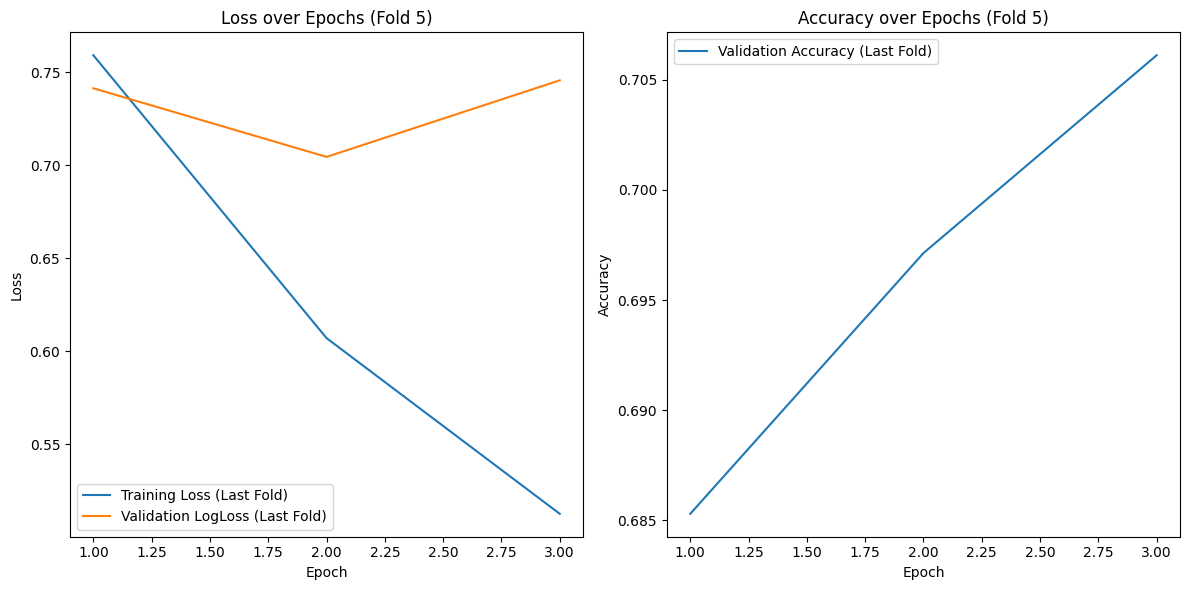

fold_1_epoch,▁▅█
fold_1_learning_rate,█▅▁
fold_1_train_loss,█▄▁
fold_1_val_CE_loss,▂▁█
fold_1_val_accuracy,▁█▆
fold_1_val_logloss,▂▁█
fold_2_epoch,▁▅█
fold_2_learning_rate,█▅▁
fold_2_train_loss,█▄▁
fold_2_val_CE_loss,█▁▄
fold_2_val_accuracy,▁▇█


In [9]:
# --- Cell 9: Training and Evaluation Loop with GroupKFold, AMP, and Gradient Accumulation ---
def format_time(elapsed_seconds):
    elapsed_rounded = int(round(elapsed_seconds))
    return str(datetime.timedelta(seconds=elapsed_rounded))

all_fold_val_logloss = []
all_fold_val_accuracy = []

for fold_num, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n========== FOLD {fold_num + 1} / {N_FOLDS} ==========")
    fold_start_time = time.time()

    df_train_fold = df_train_full.iloc[train_idx]
    df_val_fold = df_train_full.iloc[val_idx]

    print(f"  Training set size for fold {fold_num+1}: {len(df_train_fold)}")
    print(f"  Validation set size for fold {fold_num+1}: {len(df_val_fold)}")

    train_torch_dataset_fold = FeedbackPrizeDataset(df_train_fold, tokenizer, MAX_LEN, train_essay_texts_map, has_labels=True)
    val_torch_dataset_fold = FeedbackPrizeDataset(df_val_fold, tokenizer, MAX_LEN, train_essay_texts_map, has_labels=True)

    try:
        num_avail_workers = len(os.sched_getaffinity(0)) // 2
    except AttributeError:
        num_avail_workers = (os.cpu_count() // 2) if os.cpu_count() and os.cpu_count() > 1 else 0
    num_avail_workers = max(0, num_avail_workers) 

    train_dataloader_fold = DataLoader(train_torch_dataset_fold, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_avail_workers, pin_memory=True if device.type == 'cuda' else False)
    val_dataloader_fold = DataLoader(val_torch_dataset_fold, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=num_avail_workers, pin_memory=True if device.type == 'cuda' else False)

    print(f"  Initializing model for fold {fold_num+1}...")
    model = LongformerForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
    total_steps_fold = math.ceil(len(train_dataloader_fold) / ACCUMULATION_STEPS) * EPOCHS
    num_warmup_steps_fold = math.ceil(total_steps_fold * WARMUP_STEPS_RATIO)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps_fold, num_training_steps=total_steps_fold)
    
    scaler = GradScaler(enabled=(AMP_ENABLED and device.type == 'cuda'))

    best_val_logloss_fold = float('inf')
    fold_training_stats = []

    for epoch_i in range(EPOCHS):
        print(f"    ---- Epoch {epoch_i + 1} / {EPOCHS} for Fold {fold_num + 1} ----")
        
        model.train()
        total_train_loss_epoch = 0
        optimizer.zero_grad() # Zero gradients at the beginning of each epoch

        for step, batch in enumerate(tqdm(train_dataloader_fold, desc=f"Fold {fold_num+1} Epoch {epoch_i+1} Training")):
            b_input_ids = batch['input_ids'].to(device)
            b_attention_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
                outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss
                if ACCUMULATION_STEPS > 1:
                    loss = loss / ACCUMULATION_STEPS
            
            total_train_loss_epoch += loss.item() # Accumulate scaled/normalized loss
            
            if AMP_ENABLED and device.type == 'cuda':
                scaler.scale(loss).backward()
            else:
                loss.backward()

            if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(train_dataloader_fold):
                if AMP_ENABLED and device.type == 'cuda':
                    scaler.unscale_(optimizer) # Unscale before clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                if AMP_ENABLED and device.type == 'cuda':
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

        avg_train_loss_epoch = total_train_loss_epoch / (math.ceil(len(train_dataloader_fold) / ACCUMULATION_STEPS) if ACCUMULATION_STEPS > 0 else len(train_dataloader_fold))
        print(f"      Average training loss for epoch: {avg_train_loss_epoch:.4f}")

        model.eval()
        total_eval_loss_epoch = 0
        all_val_preds_probs_epoch = []
        all_val_labels_epoch = []
        for batch in tqdm(val_dataloader_fold, desc=f"Fold {fold_num+1} Epoch {epoch_i+1} Validation"):
            b_input_ids = batch['input_ids'].to(device)
            b_attention_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)
            with torch.no_grad():
                with autocast(enabled=(AMP_ENABLED and device.type == 'cuda')):
                    outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits
            total_eval_loss_epoch += loss.item()
            probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
            all_val_preds_probs_epoch.extend(probs)
            all_val_labels_epoch.extend(b_labels.to('cpu').numpy())
        
        avg_val_CE_loss_epoch = total_eval_loss_epoch / len(val_dataloader_fold)
        all_val_labels_flat_epoch = np.array(all_val_labels_epoch)
        all_val_preds_probs_stacked_epoch = np.vstack(all_val_preds_probs_epoch)
        all_val_preds_classes_epoch = np.argmax(all_val_preds_probs_stacked_epoch, axis=1)
        val_accuracy_epoch = accuracy_score(all_val_labels_flat_epoch, all_val_preds_classes_epoch)
        val_logloss_metric_epoch = log_loss(all_val_labels_flat_epoch, all_val_preds_probs_stacked_epoch, labels=label_encoder.transform(label_encoder.classes_))
        
        print(f"      Validation LogLoss: {val_logloss_metric_epoch:.4f}, Accuracy: {val_accuracy_epoch:.4f}")
        wandb.log({
            f"fold_{fold_num+1}_epoch": epoch_i + 1,
            f"fold_{fold_num+1}_train_loss": avg_train_loss_epoch,
            f"fold_{fold_num+1}_val_CE_loss": avg_val_CE_loss_epoch,
            f"fold_{fold_num+1}_val_logloss": val_logloss_metric_epoch,
            f"fold_{fold_num+1}_val_accuracy": val_accuracy_epoch,
            f"fold_{fold_num+1}_learning_rate": scheduler.get_last_lr()[0]
        })

        fold_training_stats.append({
            'fold': fold_num + 1,
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss_epoch,
            'Valid. LogLoss': val_logloss_metric_epoch,
            'Valid. Accur.': val_accuracy_epoch
        })

        if val_logloss_metric_epoch < best_val_logloss_fold:
            best_val_logloss_fold = val_logloss_metric_epoch
            save_directory = os.path.join(MODELS_OUTPUT_DIR, f"{wandb.config.model_name.split('/')[-1]}-fold-{fold_num}-best")
            if not os.path.exists(save_directory):
                os.makedirs(save_directory)
            model.save_pretrained(save_directory)
            tokenizer.save_pretrained(save_directory)
            print(f"      Best val_logloss for fold {fold_num+1} improved to {best_val_logloss_fold:.4f}. Saving model and tokenizer to {save_directory}")
    
    all_fold_val_logloss.append(best_val_logloss_fold)
    best_epoch_stats_for_fold = next((stat for stat in fold_training_stats if stat['fold'] == fold_num + 1 and abs(stat['Valid. LogLoss'] - best_val_logloss_fold) < 1e-5), None)
    if best_epoch_stats_for_fold:
        all_fold_val_accuracy.append(best_epoch_stats_for_fold['Valid. Accur.'])
    else: 
        all_fold_val_accuracy.append(fold_training_stats[-1]['Valid. Accur.'] if fold_training_stats else 0)

    print(f"  Fold {fold_num + 1} completed. Best Val LogLoss: {best_val_logloss_fold:.4f}")
    print(f"  Fold {fold_num + 1} took: {format_time(time.time() - fold_start_time)}")
    
    del model, optimizer, scheduler, train_dataloader_fold, val_dataloader_fold, train_torch_dataset_fold, val_torch_dataset_fold, scaler
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n======== K-Fold Training complete! ========\n")
avg_all_folds_logloss = np.mean(all_fold_val_logloss)
std_all_folds_logloss = np.std(all_fold_val_logloss)
avg_all_folds_accuracy = np.mean(all_fold_val_accuracy)
std_all_folds_accuracy = np.std(all_fold_val_accuracy)

print(f"Average Validation LogLoss across {N_FOLDS} folds: {avg_all_folds_logloss:.4f} +/- {std_all_folds_logloss:.4f}")
print(f"Average Validation Accuracy across {N_FOLDS} folds: {avg_all_folds_accuracy:.4f} +/- {std_all_folds_accuracy:.4f}")

wandb.summary["avg_cv_val_logloss"] = avg_all_folds_logloss
wandb.summary["std_cv_val_logloss"] = std_all_folds_logloss
wandb.summary["avg_cv_val_accuracy"] = avg_all_folds_accuracy
wandb.summary["std_cv_val_accuracy"] = std_all_folds_accuracy

if fold_training_stats:
    df_last_fold_stats = pd.DataFrame([s for s in fold_training_stats if s['fold'] == N_FOLDS])
    if not df_last_fold_stats.empty:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(df_last_fold_stats['epoch'], df_last_fold_stats['Training Loss'], label='Training Loss (Last Fold)')
        plt.plot(df_last_fold_stats['epoch'], df_last_fold_stats['Valid. LogLoss'], label='Validation LogLoss (Last Fold)')
        plt.title(f'Loss over Epochs (Fold {N_FOLDS})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(df_last_fold_stats['epoch'], df_last_fold_stats['Valid. Accur.'], label='Validation Accuracy (Last Fold)')
        plt.title(f'Accuracy over Epochs (Fold {N_FOLDS})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plot_path = os.path.join(OUTPUTS_DIR, f"training_curves_fold_{N_FOLDS}.png")
        plt.savefig(plot_path)
        print(f"Training curves plot for last fold saved to {plot_path}")
        plt.show()
        wandb.log({"last_fold_training_curves": wandb.Image(plot_path)})

wandb.finish()

## Project Summary and Results

This project aimed to classify the effectiveness of argumentative elements in student essays as "Ineffective," "Adequate," or "Effective." We built upon an initial BERT-based model, introducing several significant improvements to enhance performance and robustness.

Our initial approach used a standard BERT model. While it provided a baseline, we identified several areas for improvement. The first key change was a more thorough **Exploratory Data Analysis (EDA)**. This revealed that many full essays were longer than BERT's typical 512-token limit. This insight directly led to our second major change: switching to the **Longformer model** (`allenai/longformer-base-4096`), which can handle much longer sequences. We configured it to process up to 1024 tokens.

Thirdly, we refined how the model sees the text. Instead of just feeding it the discourse element and the full essay separately, we created a more focused input: `[CLS] discourse_type [SEP] discourse_text [SEP] context_before_discourse [SEP] context_after_discourse [SEP]`. This provides the model with the immediate surrounding text from the essay, which is likely more relevant for judging the effectiveness of a specific argument.

For more reliable evaluation and to prevent data leakage from elements within the same essay, we implemented **GroupKFold cross-validation** (5 folds), grouping by `essay_id`. This means each fold's validation set contained essays entirely unseen during that fold's training.

To speed up the training of the more complex Longformer model, we incorporated **Automatic Mixed Precision (AMP)** and **2-step gradient accumulation**. This effectively doubled our batch size and significantly reduced the training time per epoch (from over an hour to about 40 minutes locally).

Finally, for the Kaggle submission, we created an **ensemble by averaging the predictions** from the best model of each of the 5 folds. This is a common technique to improve generalization. The inference notebook was optimized for Kaggle's offline environment by ensuring all model files were loaded from a Kaggle dataset and by setting `num_workers=0` for the DataLoader to prevent multiprocessing issues.

The results of these changes are evident in the Kaggle scores:

![Kaggle Submission Scores](../outputs/result.png)

As shown in the image (comparing "inference_longformer - Version 2" to "feedback_prize_effectiveness_submission - Version 1"):
* **Previous BERT model (Version 1):** Public Score: 0.75670, Private Score: 0.73063
* **New Longformer Ensemble (Version 2):** Public Score: 0.65714, Private Score: **0.65826**

This represents a substantial improvement in the private score (LogLoss, where lower is better), moving from 0.73063 down to 0.65826. This demonstrates the effectiveness of using a model suited for longer contexts, providing more relevant contextual information, robust cross-validation, and ensembling.